<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 3
*Repeat the steps of the prostate cancer example in Section 3.2.1 using Python, first as a uni-variate problem using the book's data set and then as a multi-variate problem with data from your own project. Calculate also the p-values and the confidence intervals for the model's coefficients for the uni-variate version. Experiment, using libraries, also with subset selection.*

Los datos utilizados en este cuaderno están disponibles aquí: [datasets](https://drive.google.com/drive/folders/159GnBJQDxTY9oYqPBZzdNghyb4Gd9pDS?usp=sharing) 


In [436]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sn
warnings.filterwarnings("ignore")

## Regresión líneal en cáncer de próstata
A continuación repetiremos el ejercicio 3.2.1 del [libro](https://link.springer.com/book/10.1007/978-0-387-84858-7) en el que se aplica un modelo de regresión líneal para predecir cáncer de próstata.

Iniciamos cargando los datos de entrenamiento y almacenamos en  y `y_train`:

In [437]:
 df = pd.read_csv('prostata.csv')

In [438]:
## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,10].isin(['T'])] ## 'T' = training set
df2 = df1['lpsa']  ## 
df1 = df1[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']] ## Regresores

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [439]:
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,10].isin(['F'])] ## 'F' = test set
dft2 = dft['lpsa']
dft1 = dft[['lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']] ## Regresores

Estandarizamos los datos de los regresores `X_train` restando la media y dividiendo entre la varianza.

In [440]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

In [441]:
dft1.std(numeric_only = True) 
dft1.mean(numeric_only = True)
dft1 = dft1 - dft1.mean(numeric_only = True)
dft1 = dft1 / dft1.std(numeric_only = True) 
X_test = dft1.to_numpy()   ## Predictors
X_test = sm.add_constant(X_test)
y_test = dft2.to_numpy()   ## Outcome

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión lineal.

In [442]:
X_train = sm.add_constant(X_train)
model   = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     16.47
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           2.04e-12
Time:                        03:29:36   Log-Likelihood:                -67.505
No. Observations:                  67   AIC:                             153.0
Df Residuals:                      58   BIC:                             172.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4523      0.087     28.182      0.0

Como ejemplo podríamos habor usado también la librería  **sklearn** para obtener los mismos resultados.

In [443]:
linreg_model   = LinearRegression().fit(X_train[:, :], y_train)
linreg_prediction = linreg_model.predict(X_train)
errreg_mae = np.mean(np.abs(y_train - linreg_prediction))
print("MAE del modelo de regresión con datos de entrenamiento con sklearn:", errreg_mae)

MAE del modelo de regresión con datos de entrenamiento con sklearn: 0.4986136234494993


Ahora, calculamos los errores entre la predicción `y_pred` y los datos de entrenamiento `y_train`. Los errores son representados por un histograma.

In [444]:
#función que calcula la predicción Y[] de un X[] usando los parametros o coeficientes de regresión beta[]
def pronostica(params,X): #params:parámetros de regresión; X:datos de regresores 
    y = []
    i = 0
    for rows in X:
        y.append(np.matmul(params,X[i]))
        i = i + 1
    return(y)

In [445]:
y_pred      = pronostica(results.params,X_train)
error       = y_train - y_pred
df          = pd.DataFrame(error,y_train)
err_regress = mean_absolute_error(y_pred,y_train)

In [446]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()                                                    # o plt.save_en_algún_formato()

<Figure size 432x288 with 0 Axes>

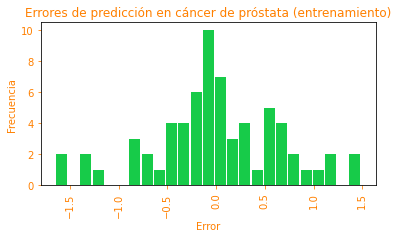

In [447]:
dibuja_hist(df,colour='#17cb49',name='hist0.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción en cáncer de próstata (entrenamiento)")

Ahora, utilizamos el modelo obtenido con los datos de entrenamiento para predecir los datos de prueba. Además,  calculamos los errores entre la predicción `y_pred2` y los datos de prueba $Yt$. Los errores de la predicción con datos de prueba son representados por un histograma.

In [448]:
y_pred2 = pronostica(results.params,X_test)
error2 = y_test - y_pred2
df = pd.DataFrame(error2,y_test)
err_regress_t = mean_absolute_error(y_test,y_pred2)

<Figure size 432x288 with 0 Axes>

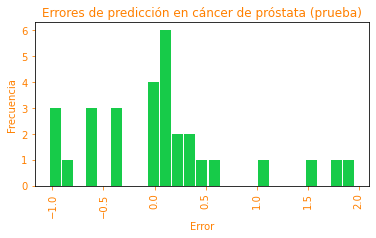

In [449]:
dibuja_hist(df,colour='#17cb49',name='hist0.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción en cáncer de próstata (prueba)")
#df.hist(column=0, bins=25, grid=False, figsize=(6,3), color='#17cb49', zorder=2, rwidth=0.9)

Ahora, calculamos el **error absoluto medio (MAE)** de los datos de entrenamiento así como de los datos de prueba en la predicción de cancer de próstata.

In [450]:
print("MAE del modelo de regresión con datos de entrenamiento:", err_regress)
print("MAE del modelo de regresión con datos de prueba:" , err_regress_t) 

MAE del modelo de regresión con datos de entrenamiento: 0.49861362344949917
MAE del modelo de regresión con datos de prueba: 0.5332335474812145


Finalmente calculamos los intervalos de confianza de los coeficientes del modelo de regresión así como los p-values:

In [451]:
print(results.conf_int(alpha=0.05, cols=None))
print(results.pvalues)

[[ 2.27815644  2.62653373]
 [ 0.44917503  0.983639  ]
 [ 0.07968993  0.50559488]
 [-0.34696416  0.0618649 ]
 [ 0.00558193  0.41843328]
 [ 0.05862448  0.56061459]
 [-0.59887957  0.02086833]
 [-0.30631449  0.26448745]
 [-0.04211288  0.59680478]]
[1.53766865e-35 1.46941496e-06 7.91789491e-03 1.68062590e-01
 4.43078420e-02 1.65053869e-02 6.69708471e-02 8.83892314e-01
 8.75462787e-02]


### Regression del mejor subconjunto a la predicción de cáncer de próstata
Aplicaremos la técnica de regression del mejor subconjunto **(Best Subset Regression)** a los datos de entrenamiento de cáncer de próstata.
Otras técnicas de reducción de dimensión y compactación de modelos de regresión puede encontrarse en: [A Comparison of Shrinkage and Selection Methods for Linear Regression](https://towardsdatascience.com/a-comparison-of-shrinkage-and-selection-methods-for-linear-regression-ee4dd3a71f16). La aplicación de este método sugiere utilizar las variables (features) [1, 2, 3, 4, 5, 6, 8]; es decir ['lweight','age','lbph','svi','lcp','gleason','pgg45'] para lograr un mínimo error entre todas las combinaciones de las variables.

In [452]:
## Loop over all possible numbers of features to be included
results = pd.DataFrame(columns=['num_features', 'features', 'MAE'])
for k in range(1, X_train.shape[1] + 1):
    # Loop over all possible subsets of size k
    for subset in itertools.combinations(range(X_train.shape[1]), k):
        subset = list(subset)        
        linreg_model = LinearRegression().fit(X_train[:, subset], y_train)
        linreg_prediction = linreg_model.predict(X_train[:, subset])
        linreg_mae = np.mean(np.abs(y_train - linreg_prediction))
        #print(subset," ",linreg_mae)
        results = results.append(pd.DataFrame([{'num_features': k,
                                                'features': subset,
                                                'MAE': linreg_mae}]))
print(results.sort_values('MAE'))
err_regress_subset = results.sort_values('MAE')['MAE'].head(1)

   num_features                     features       MAE
0             7        [1, 2, 3, 4, 5, 6, 8]  0.497997
0             8     [0, 1, 2, 3, 4, 5, 6, 8]  0.497997
0             9  [0, 1, 2, 3, 4, 5, 6, 7, 8]  0.498614
0             8     [1, 2, 3, 4, 5, 6, 7, 8]  0.498614
0             7        [1, 2, 3, 4, 5, 6, 7]  0.504766
..          ...                          ...       ...
0             2                       [0, 7]  0.904978
0             1                          [7]  0.904978
0             2                       [0, 3]  0.905767
0             1                          [3]  0.905767
0             1                          [0]  0.961085

[511 rows x 3 columns]


## Regresión lineal en predicción de demanda eléctrica

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación.

In [453]:
df = pd.read_csv('demanda.csv')

In [454]:
## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,19].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

Ahora, cargamos los datos de prueba en los arreglos `X_train` y `y_train`:

In [455]:
## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,19].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores
#X_test = dft1.to_numpy()   ## Predictors
#X_test = sm.add_constant(X_test)
#y_test = dft2.to_numpy()   ## Outcome

Estandarizamos los datos de los regresores `X_train` y `X_test` restando la media y dividiendo entre la varianza.

In [456]:
df1.std(numeric_only = True) 
df1.mean(numeric_only = True)
df1 = df1 - df1.mean(numeric_only = True)
df1 = df1 / df1.std(numeric_only = True) 
X_train = df1.to_numpy()   ## Predictors
X_train = sm.add_constant(X_train)
y_train = df2.to_numpy()   ## Outcome

In [457]:
dft1.std(numeric_only = True) 
dft1.mean(numeric_only = True)
dft1 = dft1 - dft1.mean(numeric_only = True)
dft1 = dft1 / dft1.std(numeric_only = True) 
X_test = dft1.to_numpy()   ## Predictors
X_test = sm.add_constant(X_test)
y_test = dft2.to_numpy()   ## Outcome

A continuación, obtenemos un modelo de predicción de los datos de entrenamiento usando regresión lineal.

In [458]:
model   = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())
print(results.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     374.1
Date:                Tue, 25 Jan 2022   Prob (F-statistic):          1.64e-154
Time:                        03:29:39   Log-Likelihood:                -1845.7
No. Observations:                 288   AIC:                             3713.
Df Residuals:                     277   BIC:                             3754.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8675.5029      8.826    983.002      0.0

Ahora, calculamos los errores entre la predicción `y_pred` y los datos de entrenamiento `y_train`. Los errores son representados por un histograma.

In [459]:
y_pred      = pronostica(results.params,X_train)
error       = y_train - y_pred
df          = pd.DataFrame(error,y_train)
err_regress = mean_absolute_error(y_pred,y_train)

<Figure size 432x288 with 0 Axes>

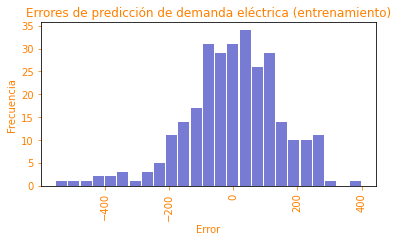

In [460]:
dibuja_hist(df,colour='#777bd4',name='dummy.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción de demanda eléctrica (entrenamiento)")

Ahora, utilizamos el modelo obtenido con los datos de entrenamiento para predecir los datos de prueba. Además,  calculamos los errores entre la predicción `y_pred2` y los datos de prueba $Yt$. Los errores de la predicción con datos de prueba son representados por un histograma.

In [461]:
y_pred2 = pronostica(results.params,X_test) #print(y_pred2)
error2 = y_test - y_pred2
df = pd.DataFrame(error2,y_test)
err_regress_t = mean_absolute_error(y_test,y_pred2)

<Figure size 432x288 with 0 Axes>

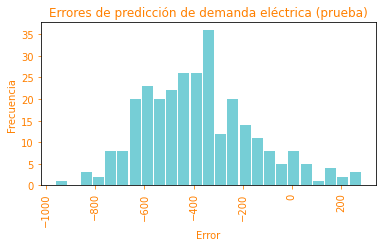

In [462]:
dibuja_hist(df,colour='#76ced6',name='dummy.png',Xlabel="Error",Ylabel="Frecuencia",title="Errores de predicción de demanda eléctrica (prueba)")
#df.hist(column=0, bins=25, grid=False, figsize=(6,3), color='#17cb49', zorder=2, rwidth=0.9)

In [463]:
bias.bias(y_test, y_pred2, axis=0)

-379.36295032986135

Ahora, calculamos el **error absoluto medio (MAE)** de los datos de entrenamiento así como de los datos de prueba en la predicción de cancer de próstata.

In [464]:
print("MAE del modelo de regresión con datos de entrenamiento:", err_regress)
print("MAE del modelo de regresión con datos de prueba:" , err_regress_t) 

MAE del modelo de regresión con datos de entrenamiento: 112.47212814878469
MAE del modelo de regresión con datos de prueba: 394.56277116389936


### Regression del mejor subconjunto a la predicción de pronóstico de demanda eléctrica
Aplicaremos la técnica de regression del mejor subconjunto **(Best Subset Regression)** a los datos de entrenamiento de pronóstico de demanda.
Otras técnicas de reducción de dimensión y compactación de modelos de regresión puede encontrarse en: [A Comparison of Shrinkage and Selection Methods for Linear Regression](https://towardsdatascience.com/a-comparison-of-shrinkage-and-selection-methods-for-linear-regression-ee4dd3a71f16). La aplicación de este método sugiere utilizar las variables (features) (0, 1, 2, 3, 5, 7, 9]; es decir [X1, X2, X3, X6, X8, X10] para lograr un mínimo error entre todas las combinaciones de las variables.

In [465]:
## Loop over all possible numbers of features to be included
results = pd.DataFrame(columns=['num_features', 'features', 'MAE'])
for k in range(1, X_train.shape[1] + 1):
    # Loop over all possible subsets of size k
    for subset in itertools.combinations(range(X_train.shape[1]), k):
        subset = list(subset)        
        linreg_model = LinearRegression().fit(X_train[:, subset], y_train)
        linreg_prediction = linreg_model.predict(X_train[:, subset])
        linreg_mae = np.mean(np.abs(y_train - linreg_prediction))
        #print(subset," ",linreg_mae)
        results = results.append(pd.DataFrame([{'num_features': k,
                                                'features': subset,
                                                'MAE': linreg_mae}]))
print(results.sort_values('MAE'))
err_regress_subset = results.sort_values('MAE')['MAE'].head(1)

   num_features                      features         MAE
0             7         [0, 1, 2, 3, 5, 7, 9]  110.867369
0             6            [1, 2, 3, 5, 7, 9]  110.867369
0             6            [0, 1, 2, 3, 5, 7]  110.919145
0             5               [1, 2, 3, 5, 7]  110.919145
0             9  [0, 1, 2, 3, 4, 5, 7, 9, 10]  110.991807
..          ...                           ...         ...
0             1                           [7]  152.292525
0             2                        [0, 7]  152.292525
0             1                          [10]  157.380566
0             2                       [0, 10]  157.380566
0             1                           [0]  474.064100

[2047 rows x 3 columns]


Finalmente aquí dejamos algunas ligas interesantes: 

1.    [Selección de predictores, regularización ridge, lasso, elastic net y reducción de dimensionalidad](https://www.cienciadedatos.net/documentos/31_seleccion_de_predictores_subset_selection_ridge_lasso_dimension_reduction#Introducci%C3%B3n)


